In [1]:
import torch

 # `maskrcnn_resnet50_fpn`
 
 ```

    Constructs a Mask R-CNN model with a ResNet-50-FPN backbone.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format,  with values of ``x``
          between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box
        - masks (``UInt8Tensor[N, H, W]``): the segmentation binary masks for each instance

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN, and the mask loss.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format,  with values of ``x``
          between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
        - labels (``Int64Tensor[N]``): the predicted labels for each image
        - scores (``Tensor[N]``): the scores or each prediction
        - masks (``UInt8Tensor[N, 1, H, W]``): the predicted masks for each instance, in ``0-1`` range. In order to
          obtain the final segmentation masks, the soft masks can be thresholded, generally
          with a value of 0.5 (``mask >= 0.5``)

    Mask R-CNN is exportable to ONNX for a fixed batch size with inputs images of fixed size.

    Example::

        >>> model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
        >>>
        >>> # optionally, if you want to export the model to ONNX:
        >>> torch.onnx.export(model, x, "mask_rcnn.onnx", opset_version = 11)

    Arguments:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
        pretrained_backbone (bool): If True, returns a model with backbone pre-trained on Imagenet
        num_classes (int): number of output classes of the model (including the background)
        trainable_backbone_layers (int): number of trainable (not frozen) resnet layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable.

```

# I/O Functions

In [40]:
# From: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
import numpy as np


def rle2bbox(rle, shape):
    '''
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    
    Note on image vs np.array dimensions:
    
        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1


# From: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def masks_to_bboxes(in_mask_list, N, shape=(768,768)):
    if N == 0:
        return None
    bbox_array = np.empty((N, 4), dtype=np.float32)
    i = 0
    for rle in in_mask_list:
        if isinstance(rle, str):
            # bbox = tuple(x1, y1, x2, y2)
            bbox = rle2bbox(rle, shape)
            bbox_array[i,:] = bbox
            i += 1
    return torch.from_numpy(bbox_array)


def masks_as_tensor(in_mask_list, N, shape=(768, 768)):
    if N == 0:
        return None
    masks = np.empty((N, shape[0], shape[1]), dtype=np.uint8)
    i = 0
    for rle in in_mask_list:
        if isinstance(rle, str):
            (x0, y0, x1, y1) = rle_decode(rle)
            # Make sure mask is greater than 1 pixel wide and tall
            if x0 >= x1 or y0 >= y1:
                masks = masks[:-1, :, :] 
            else:
                masks[i, :, :] = (x0, y0, x1, y1)
                i += 1
    
    return torch.from_numpy(masks)


def is_valid(rle, shape=(768,768)):
    width, height = shape
    xmin, ymin, xmax, ymax = rle2bbox(rle, shape)
    if xmin >= 0 and xmax <= width and xmin < xmax and ymin >= 0 and ymax <= height and ymin < ymax:
        return True
    return False


def make_target(in_mask_list, N, shape=(768, 768)):
    if N == 0:
        return None
    bbox_array = np.empty((N, 4), dtype=np.float32)
    masks = np.empty((N, shape[0], shape[1]), dtype=np.uint8)
    labels = torch.ones((N,), dtype=torch.int64)
    i = 0
    for rle in in_mask_list:
        if isinstance(rle, str):
            # bbox = tuple(x1, y1, x2, y2)
            bbox = rle2bbox(rle, shape)
            bbox_array[i,:] = bbox
            mask = rle_decode(rle)
            masks[i, :, :] = mask
        i += 1
    areas = (bbox_array[:, 3] - bbox_array[:, 1]) * (bbox_array[:, 2] - bbox_array[:, 0])
    # suppose all instances are not crowd
    is_crowd = torch.zeros((N,), dtype=torch.int64)
    target = {
        'boxes': torch.from_numpy(bbox_array),
        'labels': labels,
        'masks': torch.from_numpy(masks),
        'area': torch.from_numpy(areas),
        'iscrowd': is_crowd
    }
    return target

In [41]:
import numpy as np

from torch.utils.data import Dataset
from skimage.io import imread


class ShipDataset(Dataset):
    def __init__(self, in_df, transforms=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transforms = transforms
        self.mode = mode
#        self.img_transform = Compose([
#        ToTensor(),
#        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        in_mask_list = self.image_masks[idx]
        N = sum([1 for i in in_mask_list if isinstance(i, str)])
        for i, rle in enumerate(in_mask_list):
            if not is_valid(rle):
                if N > 1:
                    N -= 1
                    in_mask_list = np.delete(in_mask_list, i)
                elif len(self) > idx + 1:
                    return self.__getitem__(idx + 1)
                else:
                    return self.__getitem__(0)

        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)

        image = imread(rgb_path)

        # Make target dict
        target = make_target(in_mask_list, N, shape=(768,768))
        
        # Make image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
               
        if self.transforms is not None:
            image, mask = self.transforms(image, target)

        return image, target

### I/O Function Tests

In [28]:
bbox_tensor = np.empty((1, 4), dtype=np.int16)
i = 0
bbox_tensor[i,:] = (1,2,3,4)
torch.from_numpy(bbox_tensor).shape[0]

shape = (500, 500)
masks = np.empty((1, shape[0], shape[1]))

In [5]:
#in_mask_list = ['85642 6 86409 8 87176 10 87943 11']
#N = sum([1 for i in in_mask_list if isinstance(i, str)])
# Make target dict
#masks = masks_as_tensor(in_mask_list, N)
#bboxes = masks_to_bboxes(in_mask_list, N)
#labels = torch.tensor([0 for i in range(N)], dtype=torch.int64)
#target = {
#          'boxes': bboxes,
#          'labels': labels,
#          'masks': masks
#}
#
#target

In [6]:
#import torch
#in_mask_list = ['85642 6 86409 8 87176 10 87943 11']
#bbox = masks_to_bboxes(in_mask_list, 1)
#if is_valid(bbox):
#    pass

# `maskrcnn_resnet50_fpn` Code

From : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [29]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
#import os
#
#
#%%shell
#
# Download TorchVision repo to use some files from
# references/detection
#os.system(
#    'git clone https://github.com/pytorch/vision.git & \
#    cd vision & \
#    git checkout v0.3.0 & \
#)

In [9]:
#!cp vision/references/detection/utils.py ./ 
#!cp vision/references/detection/transforms.py ./ 
#!cp vision/references/detection/coco_eval.py ./ 
#!cp vision/references/detection/engine.py ./ 
#!cp vision/references/detection/coco_utils.py ./

In [30]:
!pip install pycocotools

from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [59]:
import os 
import pandas as pd


def get_box_size(rle):
    if type(rle) is not str:
        return float('inf')
    s = rle.split()
    length = sum([int(x) for x in s[1:][::2]])
    return length


def filter_ids(masks, max_thresh=300, n_neg_samples = 50000):
    # Remove duplicates using set
    id_set_1 = set(masks.loc[masks['EncodedPixels'].apply(
        lambda x: get_box_size(x) <= max_thresh
        )]['ImageId'].tolist())
#    id_set_2 = set(masks.loc[masks['EncodedPixels'].apply(
#        lambda x: isinstance(x, str)
#        )]['ImageId'].tolist())
#    id_set_2 = set(masks.drop(
#        masks[masks.EncodedPixels.notnull()].index).sample(50000).index)
    id_set_2 = set(masks.drop(
            masks[masks.EncodedPixels.notnull()].index
            ).sample(n_neg_samples).ImageId.tolist())
    
    return list(id_set_1.union(id_set_2))


# Make filepaths
ship_dir = r'../../airbus-dataset/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test')

masks = pd.read_csv('../../airbus-dataset/train_ship_segmentations_v2.csv')

max_thresh = 300
# Pandas == cancer
labeled_masks = masks.groupby('ImageId').apply(lambda grp: grp.EncodedPixels.apply(
    lambda rle: get_box_size(rle) <= max_thresh).any()
                                               ).reset_index(name='counts')

filtered_masks = masks[
    masks.ImageId.isin(labeled_masks[labeled_masks.counts == True].ImageId)]
#null_masks = masks[
#    masks.EncodedPixels.isnull()].sample(filtered_masks.shape[0],random_state=42)
#masks = pd.concat((filtered_masks, null_masks))
#masks.shape[0] == filtered_masks.shape[0] * 2

In [60]:
# use our dataset and defined transformations
dataset = ShipDataset(filtered_masks, get_transform(train=True))
dataset_valid = ShipDataset(filtered_masks, get_transform(train=False))

dataset.__len__()
dataset_valid.__len__()

20997

In [61]:

# split the dataset in train and validation set
valid_size = 3000
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-valid_size])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[-valid_size:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=16, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [63]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1e1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

Epoch: [0]  [   0/1125]  eta: 1:45:05  lr: 0.000010  loss: 4.6121 (4.6121)  loss_classifier: 0.6859 (0.6859)  loss_box_reg: 0.0670 (0.0670)  loss_mask: 2.1050 (2.1050)  loss_objectness: 1.5313 (1.5313)  loss_rpn_box_reg: 0.2229 (0.2229)  time: 5.6048  data: 1.7112  max mem: 11127
Epoch: [0]  [  10/1125]  eta: 1:17:18  lr: 0.000060  loss: 4.1372 (4.1699)  loss_classifier: 0.6197 (0.5911)  loss_box_reg: 0.0512 (0.0558)  loss_mask: 1.5464 (1.6595)  loss_objectness: 1.6124 (1.6231)  loss_rpn_box_reg: 0.2229 (0.2403)  time: 4.1597  data: 0.2100  max mem: 11127
Epoch: [0]  [  20/1125]  eta: 1:15:19  lr: 0.000110  loss: 2.1193 (2.9797)  loss_classifier: 0.3779 (0.4308)  loss_box_reg: 0.0625 (0.0652)  loss_mask: 1.1023 (1.2750)  loss_objectness: 0.7069 (1.0131)  loss_rpn_box_reg: 0.1716 (0.1956)  time: 4.0142  data: 0.0582  max mem: 11127
Epoch: [0]  [  30/1125]  eta: 1:14:12  lr: 0.000160  loss: 1.1208 (2.3545)  loss_classifier: 0.1852 (0.3428)  loss_box_reg: 0.0721 (0.0708)  loss_mask: 0.634

In [16]:
#%tb

SystemExit: 1

In [52]:
width, height = (768,768)
for i in range(len(dataset) - 4000):
    targets = dataset[4000 + i][1]
    for xmin, ymin, xmax, ymax in targets['boxes']:
        assert xmin >= 0
        assert xmax <= width
        assert xmin < xmax

        assert ymin >= 0
        assert ymax <= height
        assert ymin < ymax
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [76]:
# pick one image from the test set
img, _ = dataset_valid[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [65]:
prediction

[{'boxes': tensor([[633.8049, 469.3973, 661.9486, 492.7008],
          [369.1574, 592.9528, 382.1175, 606.3325],
          [688.2825, 478.9373, 708.0613, 504.2677],
          [603.0339, 530.7689, 623.9144, 558.0306],
          [723.0441, 303.5369, 754.6412, 336.8972],
          [587.8437, 585.4587, 605.7213, 604.7251],
          [633.4344, 552.7205, 672.9872, 597.3200],
          [607.2651, 546.0128, 620.5696, 559.9417],
          [588.3126, 591.6523, 597.6562, 603.9195],
          [360.3520, 592.3054, 382.8099, 615.3967],
          [641.9447, 553.3285, 662.2687, 567.3958],
          [593.6353, 587.7236, 602.1863, 601.6262],
          [624.8251, 545.0291, 636.1366, 557.7219],
          [603.7723, 529.9333, 619.0206, 549.6288],
          [604.6967, 543.3305, 617.4700, 557.6991],
          [686.3835, 480.2610, 699.5402, 499.5663],
          [608.4889, 529.6317, 619.2720, 542.5476],
          [739.8564, 326.9034, 768.0000, 361.1963],
          [693.6594, 483.1964, 706.8341, 501.7032],
   

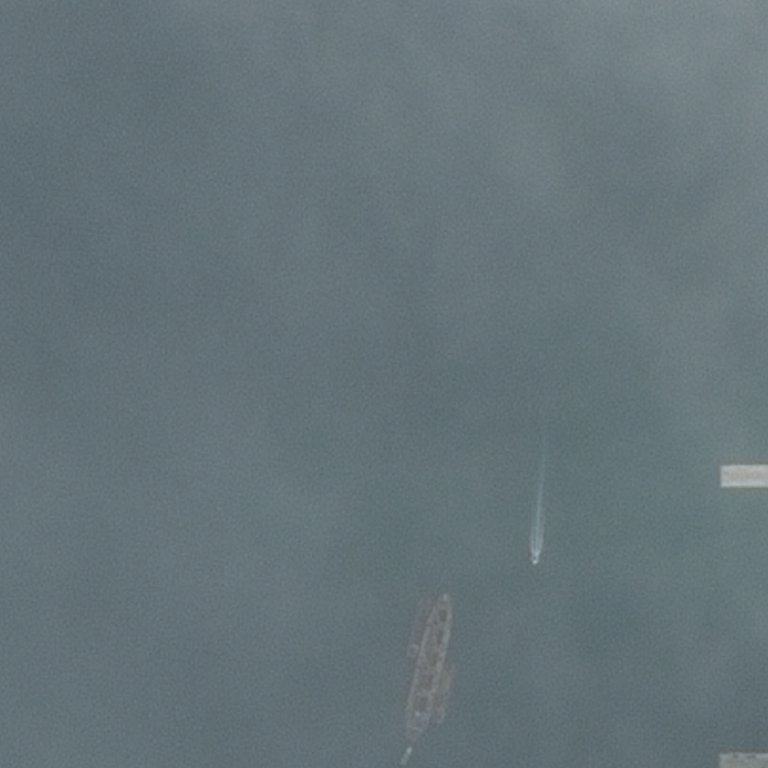

In [77]:
from PIL import Image


Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

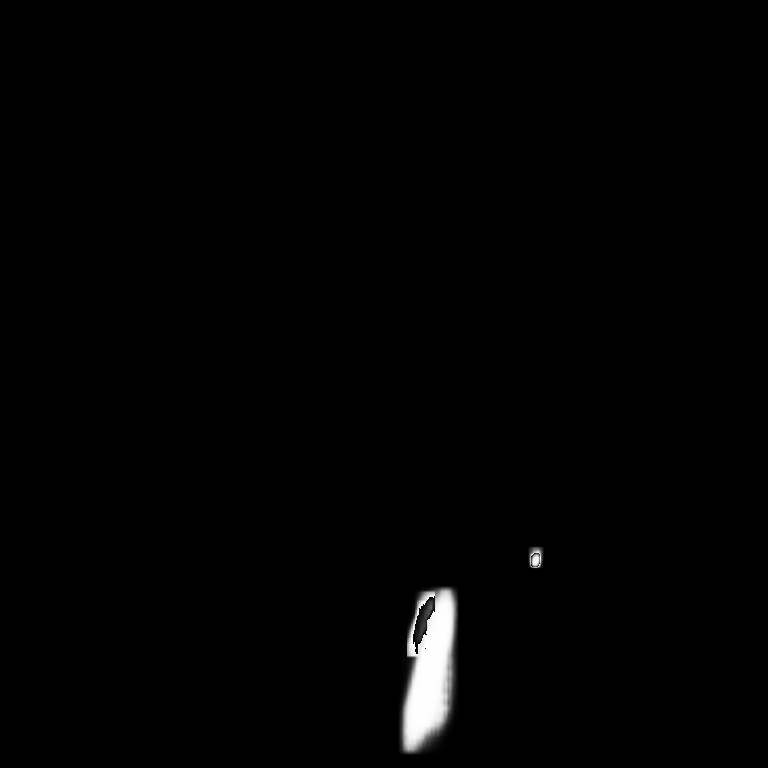

In [78]:
n_pos = len(prediction[0]['scores'][(prediction[0]['scores'] > 0.75)])

masks = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
for mask in prediction[0]['masks'][1:n_pos, 0]:
    masks += mask.mul(255).byte().cpu().numpy()
    
Image.fromarray(masks)

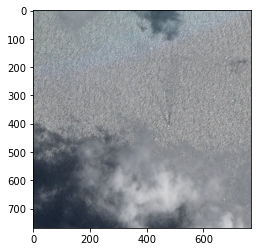

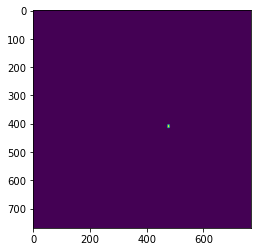

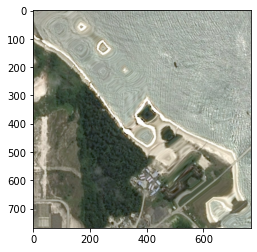

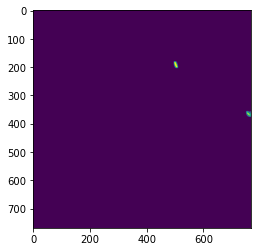

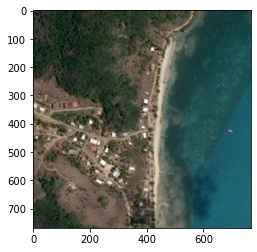

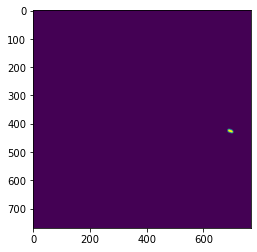

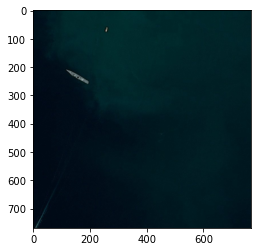

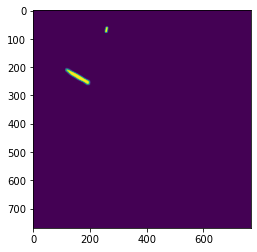

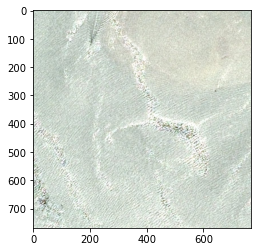

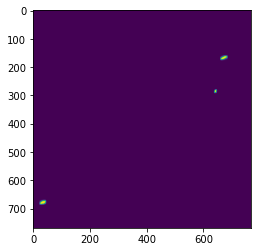

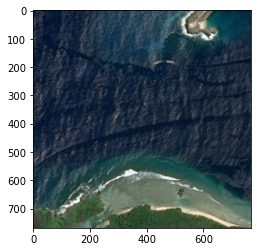

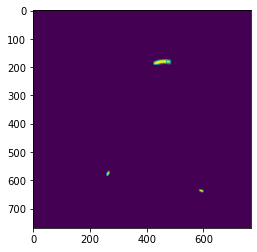

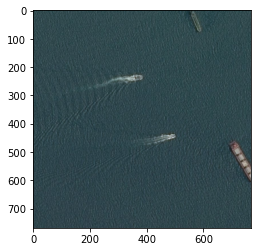

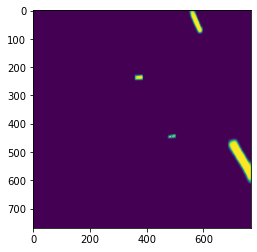

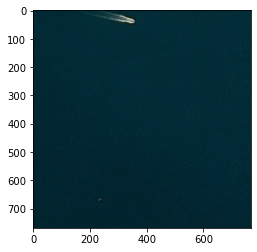

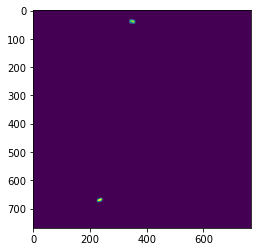

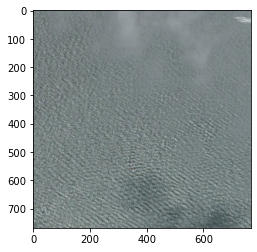

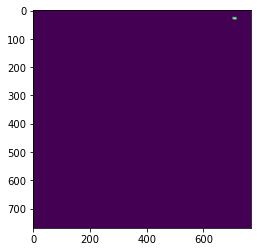

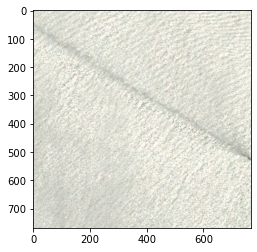

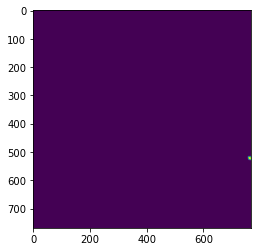

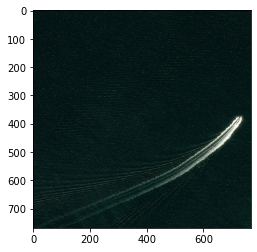

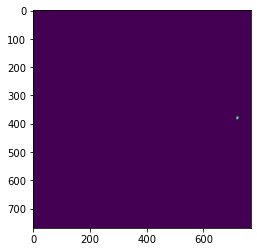

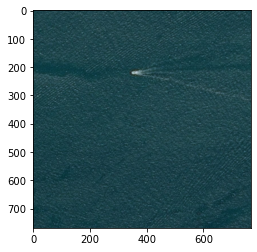

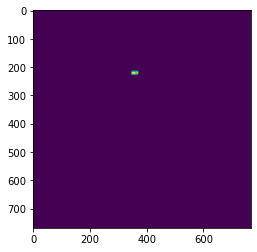

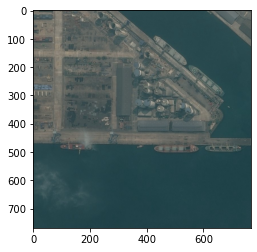

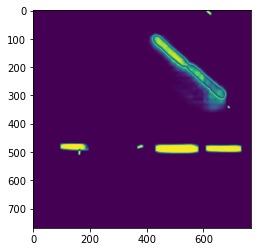

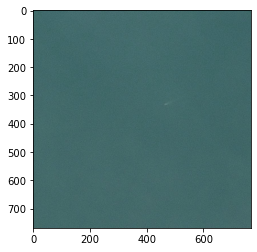

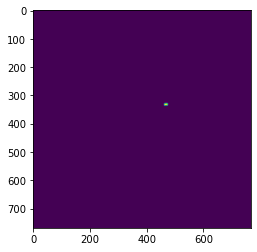

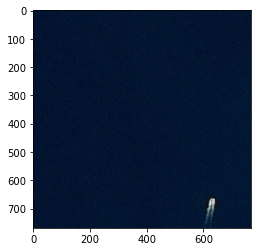

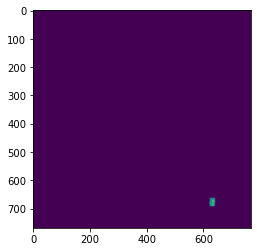

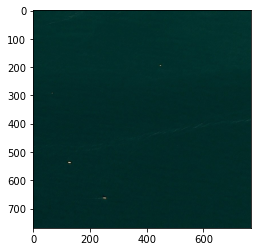

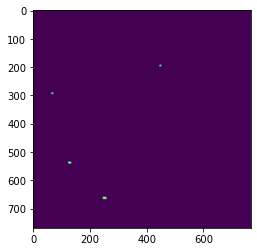

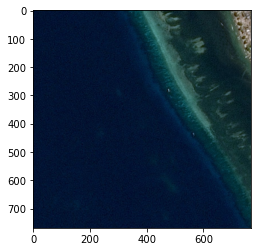

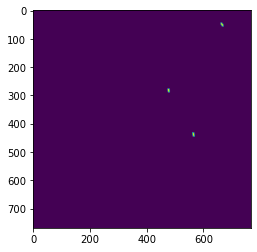

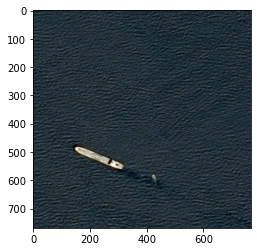

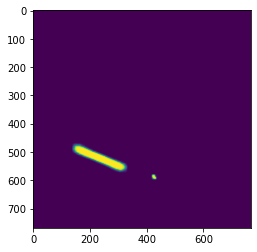

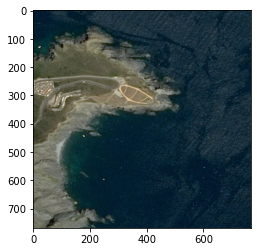

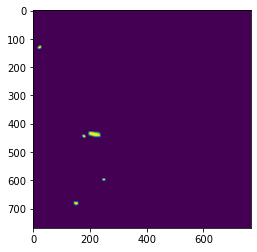

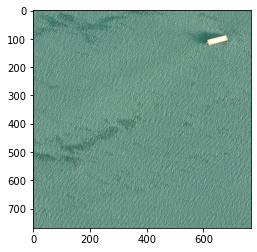

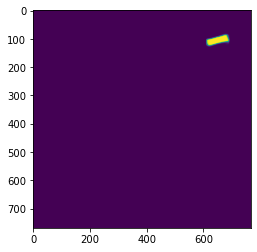

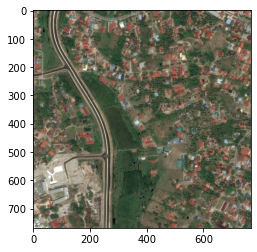

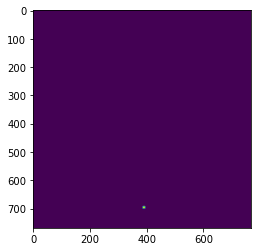

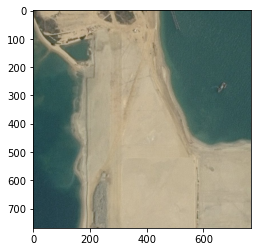

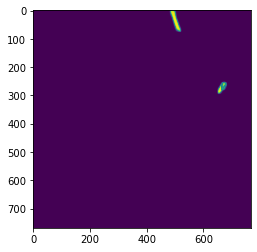

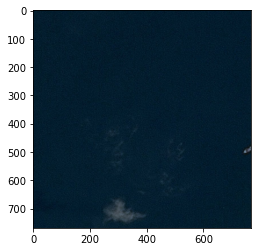

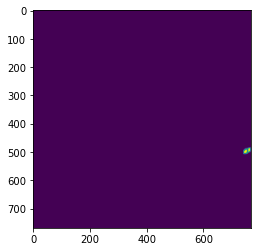

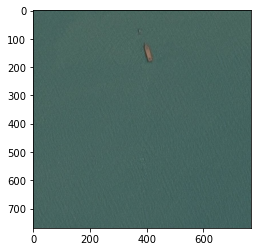

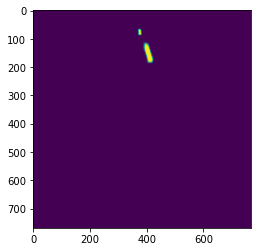

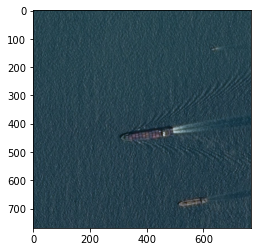

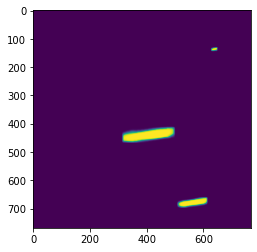

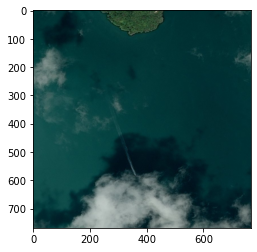

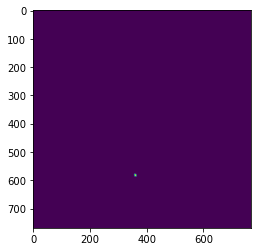

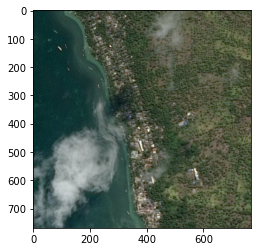

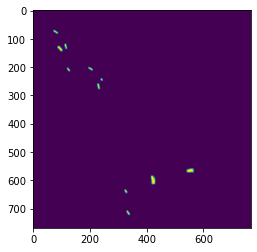

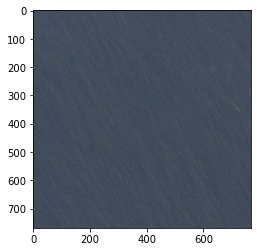

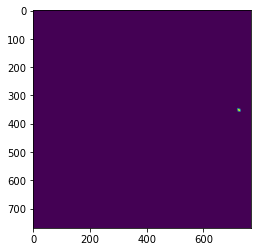

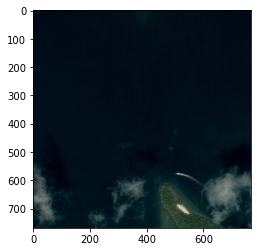

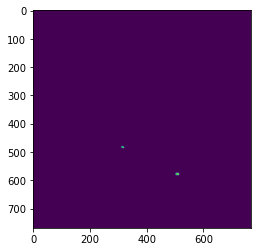

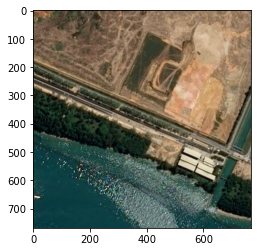

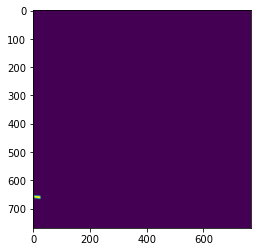

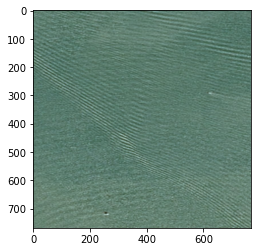

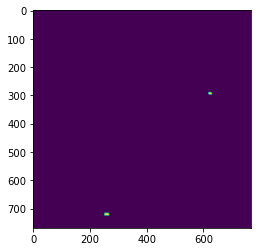

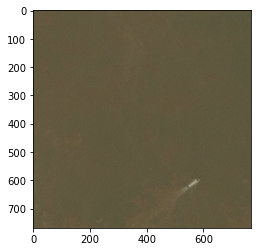

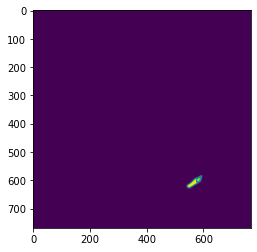

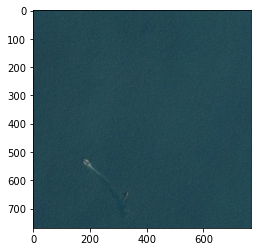

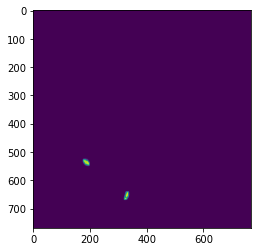

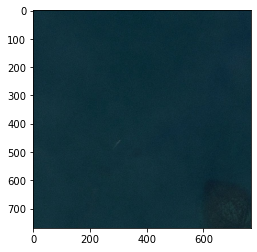

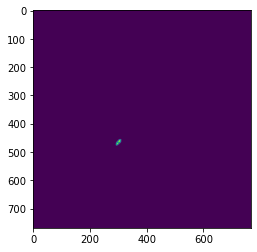

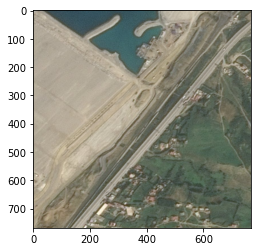

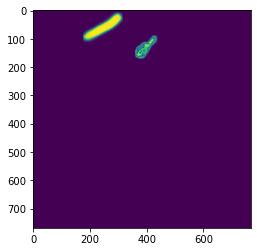

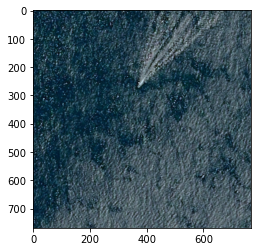

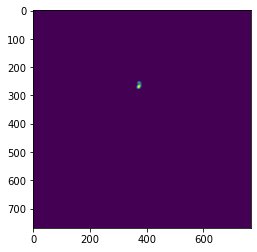

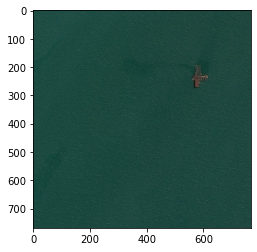

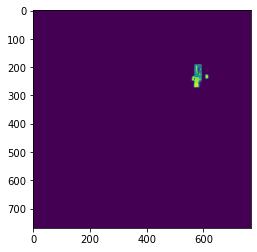

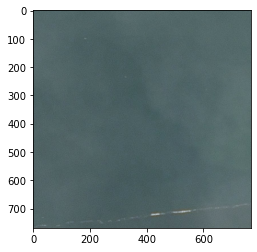

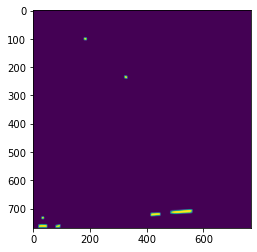

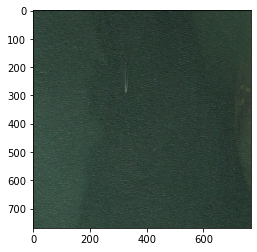

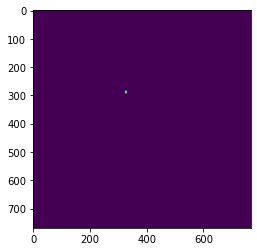

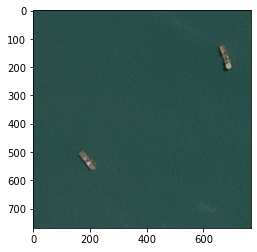

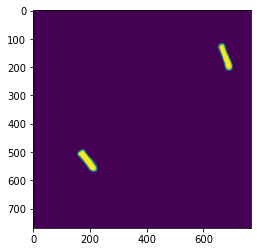

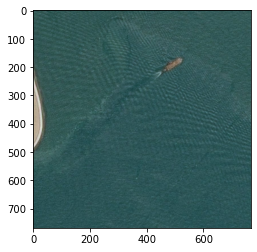

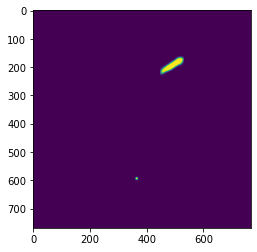

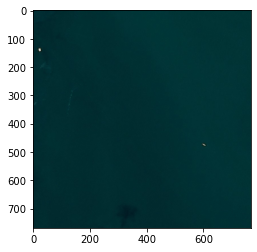

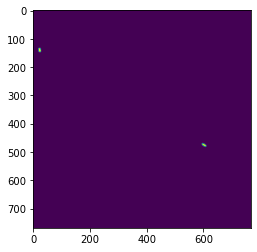

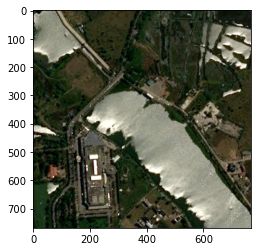

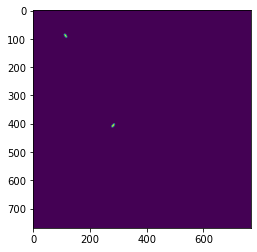

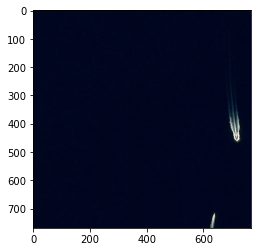

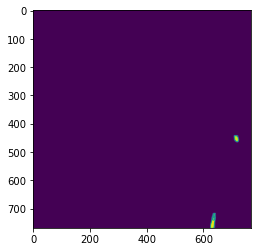

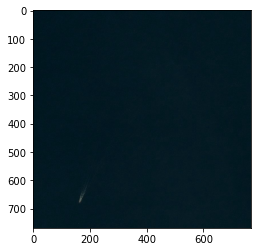

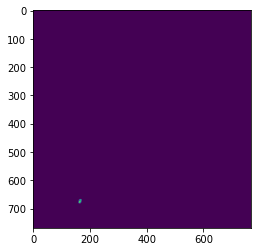

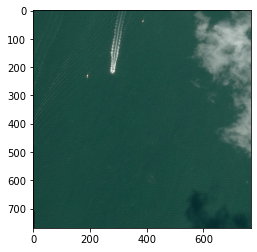

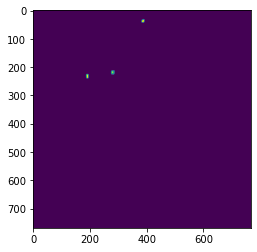

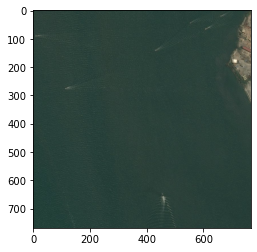

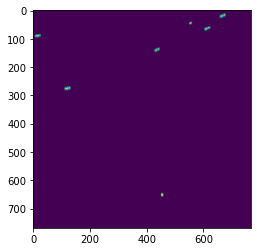

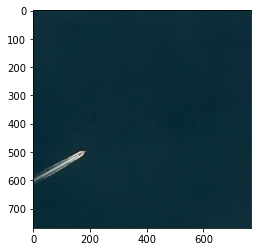

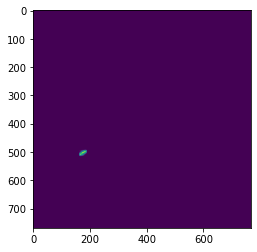

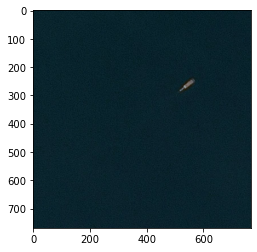

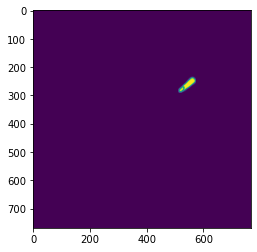

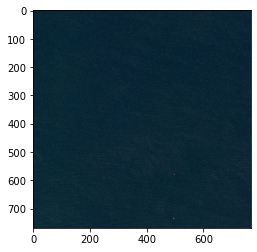

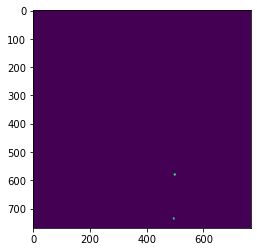

In [88]:
import matplotlib.pyplot as plt

from PIL import Image


n_images = 50
for i in range(1000, 1000 + n_images):
    # pick one image from the test set
    img, _ = dataset_valid[i]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    
    n_pos = len(prediction[0]['scores'][(prediction[0]['scores'] > 0.50)])

    masks = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
    for mask in prediction[0]['masks'][1:n_pos, 0]:
        masks += mask.mul(255).byte().cpu().numpy()
    
    fig, axarr = plt.subplots(1, 2, figsize=(30, 80))
    axarr[0].axis('off')
    axarr[1].axis('off')
    #axarr[2].axis('off')
    #axarr[3].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(Image.fromarray(masks))
    #axarr[2].imshow(img)
    #axarr[2].imshow(all_masks, alpha=0.4)
    #axarr[3].imshow(first_mask)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()